In [40]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from utils import masks_as_image

# Define the constants
TRAIN_FOLDER = "./ship_detection_data/train_v2/"
TEST_FOLDER = "./ship_detection_data/test_v2/"
CSV_PATH = "./ship_detection_data/train_ship_segmentations_v2.csv"

TEST_SIZE = 0.3

Examine how many files do we have in test and train folders

In [41]:
for path in [TRAIN_FOLDER, TEST_FOLDER]:
    print(f"{len(os.listdir(path))} images are in {path}")

192556 images are in ./ship_detection_data/train_v2/
15606 images are in ./ship_detection_data/test_v2/


**Observe the dataset**

In [42]:
train = pd.read_csv(CSV_PATH)

train.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [43]:
print(f"Total number of images: {len(train['ImageId'].unique())}")

Total number of images: 192556


Let's see a random image from dataset

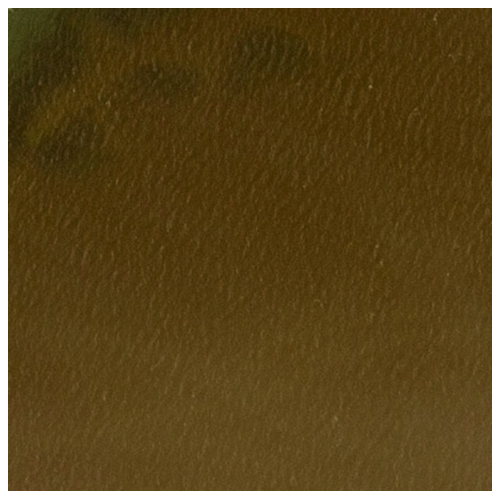

In [44]:
plt.figure(figsize=(8,8), dpi=80)
image_path = train["ImageId"].sample(1).values[0]

img = cv2.imread(TRAIN_FOLDER + image_path)
plt.imshow(img)
plt.axis('off');

Examine how many of images are empty (does not contain any ship)

In [45]:
not_empty = pd.notna(train['EncodedPixels'])
print(f"{not_empty.sum()} masks in {train[not_empty].ImageId.nunique()} images")
print(f"{(~not_empty).sum()} empty images in {train.ImageId.nunique()} total images")

81723 masks in 42556 images
150000 empty images in 192556 total images


We have an imbalanced dataset. Start dealing with it by knowing the distribution of ships on the images

In [46]:
train['ships'] = train['EncodedPixels'].apply(lambda x: 1 if isinstance(x, str) else 0)

# Get the number of ships in each image
unique_train = train.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
train.drop(['ships'], axis=1, inplace=True)
unique_train.head()

,ImageId,ships
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0


In [47]:
# Get max and min number of ships per image

print(f"Max number of ships on image is {unique_train['ships'].max()}")
print(f"Min number of ships on image is {unique_train['ships'].min()}")

Max number of ships on image is 15
Min number of ships on image is 0


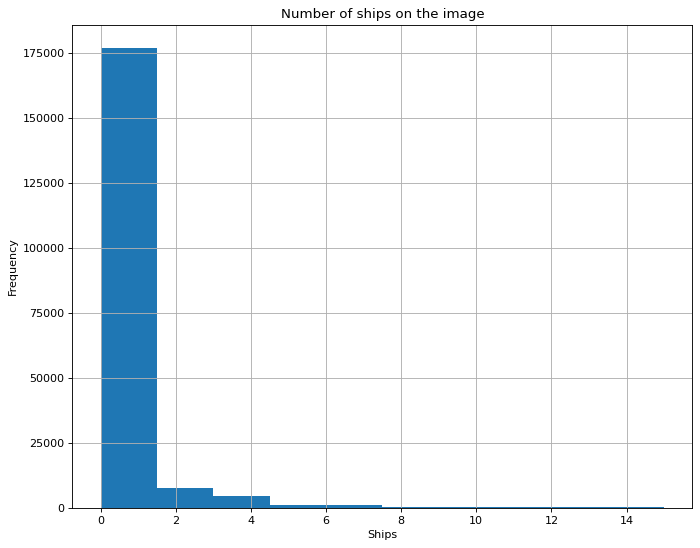

In [48]:
fig, ax = plt.subplots(figsize=(10,8), dpi=80)

unique_train['ships'].hist(ax=ax, bins=10)

plt.title('Number of ships on the image')
plt.xlabel('Ships')
plt.ylabel('Frequency');

**Working with NaNs**

We have to replace NaN value in RLE to empty string for future modelling

In [49]:
train['EncodedPixels'] = train['EncodedPixels'].fillna("")
train.head()

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


**Spliting into train and validation datasets**

To get balance in each set we stratify by the number of ships

In [50]:
train_ids, valid_ids = train_test_split(unique_train,
                                        test_size=TEST_SIZE,
                                        stratify=unique_train['ships'])

train_df = pd.merge(train, train_ids)
valid_df = pd.merge(train, valid_ids)

print(f"{train_df.shape[0]} training images")
print(f"{valid_df.shape[0]} validation images")

162201 training images
69522 validation images


**Undersampling empty images**

We have to undersample empty images to make the datasets more balanced. We will select a random subset of samples which does not contain ship.

In [51]:
train_df['ships'].value_counts()

ships
0     105000
1      18973
2      10744
3       6204
4       4540
5       3235
6       2760
7       1988
8       1784
9       1530
10      1180
11      1111
12      1044
14       742
15       690
13       676
Name: count, dtype: int64

Create a function to undersample empty images

In [52]:
def undersample_df(df):
    zero_ships = df[df['ships']==0].sample(n=int(len(df)*0.1))
    nonzero_ships = df[df['ships'] != 0]
    return pd.concat((zero_ships, nonzero_ships), axis=0)

In [53]:
print("Before Undersampling:")
print(f"{train_df.shape[0]} training images")
print(f"{valid_df.shape[0]} validation images")
print("=========================================")

train_df = undersample_df(train_df)
valid_df = undersample_df(valid_df)

print("After Undersampling:")
print(f"{train_df.shape[0]} training images")
print(f"{valid_df.shape[0]} validation images")

Before Undersampling:
162201 training images
69522 validation images
After Undersampling:
73421 training images
31474 validation images


Let's look at the new distribution of number of ships on image

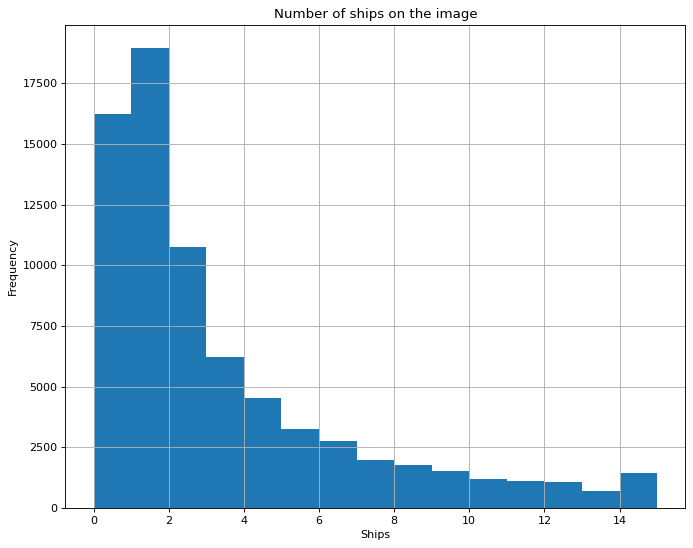

In [54]:
fig, ax = plt.subplots(figsize=(10,8), dpi=80)

train_df['ships'].hist(ax=ax, bins=15)

plt.title('Number of ships on the image')
plt.xlabel('Ships')
plt.ylabel('Frequency');

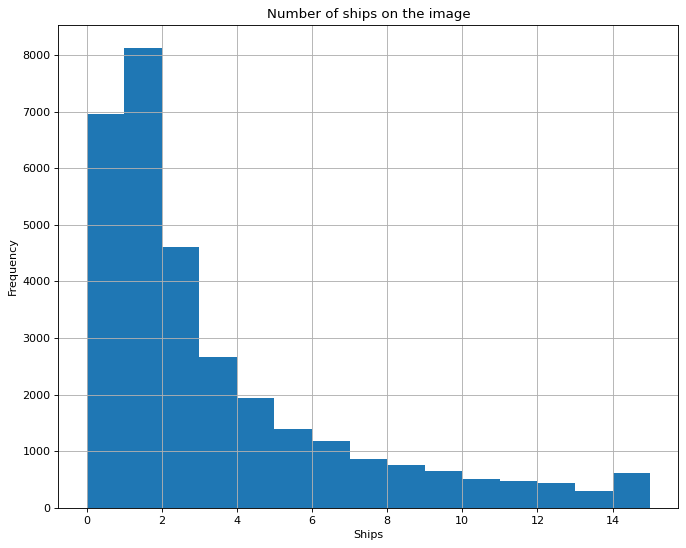

In [55]:
fig, ax = plt.subplots(figsize=(10,8), dpi=80)

valid_df['ships'].hist(ax=ax, bins=15)

plt.title('Number of ships on the image')
plt.xlabel('Ships')
plt.ylabel('Frequency');

We have now much balanced dataset both for training and validation datasets.

**Check the image and corresponding RLE mask**

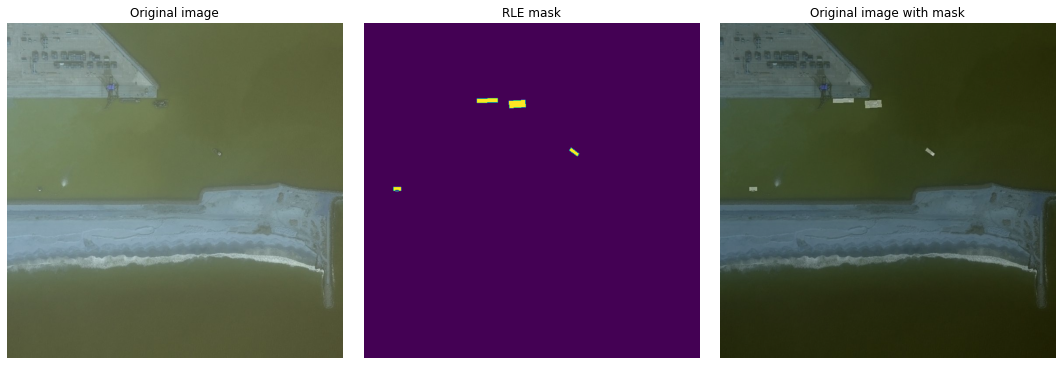

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

#take one of the images
image_path = "000194a2d.jpg"

img = cv2.imread(TRAIN_FOLDER + image_path)
ax1.imshow(img)
ax1.axis('off')
ax1.set_title('Original image')

rle = train[train['ImageId']=="000194a2d.jpg"]['EncodedPixels'].to_list()
img_rle = masks_as_image(rle)
ax2.imshow(img_rle)
ax2.axis('off')
ax2.set_title('RLE mask')

img_overlay_rle = np.tile(img_rle, 3)

# Normalize pixel values to the range [0, 1]
img_overlay_rle = (img_overlay_rle - img_overlay_rle.min())/(img_overlay_rle.max() - img_overlay_rle.min()).astype(np.float32)
img = (img - img.min())/(img.max()-img.min()).astype(np.float32)

# Mix 2 images in one
overall_img = cv2.addWeighted(src1=img, alpha=0.65, src2=img_overlay_rle, beta=0.35, gamma=0.0)

ax3.imshow(overall_img)
ax3.axis('off')
ax3.set_title('Original image with mask')

plt.tight_layout()
plt.show()

**Summary: Exploratory Data Analysis (EDA)**

Strategic undersampling addressed a significant class imbalance, enhancing dataset balance for improved model training.

The examination revealed a range of [0 - 15] ships per image. 

Additionally, systematic handling of missing values in Run-Length Encoded (RLE) masks ensures compatibility with the Keras model.